 This project will explore house prices in major cities around ontario and do a prediction on house prices.

- Import packages and read in csvs scraped using Octoparse
- Append all dataframes into one dataframe

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
from dateutil.relativedelta import relativedelta
%matplotlib inline

In [31]:
houses = pd.read_csv('houses.csv')

In [33]:
houses.head()

,Address,CityArea,Type,Price,Price1,style_listingdetail__b0bdg,style_listingdetail__b0bdg2,style_listingdetail__b0bdg3,style_component__qn84q
0,25 Woodward Ave,"Markham, Grandview L3T1E3",House,"$2,150,000","List Price$1,950,000",4 Bed,4 Bath,2000–2500 sqft,5 days
1,2520 Orchestrate Dr,"Oshawa, Windfields L1L 0R3",House,"$1,265,000","List Price$1,299,900",4 Bed,3 Bath,2000–2500 sqft,5 days
2,160 Burcher Rd,"Ajax, South East L1S2R5",House,"$918,000","List Price$949,000",3 Bed,2 Bath,N/A sqft,Sold 5 Days Ago
3,7359 Sigsbee Dr,"Mississauga, Malton L4T3S5",House,"$1,150,000","List Price$1,149,000",3 Bed,2 Bath,N/A sqft,Sold 5 Days Ago
4,2729 Bushland Cres,"Mississauga, Clarkson L5J1X8",House,"$1,270,000","List Price$1,200,000",3 Bed,2 Bath,1100–1500 sqft,5 days


Checking the datatype for the columns
some columns need to be renamed and cleaned 

In [34]:
#check data types for different columns 
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38986 entries, 0 to 38985
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Address                      38986 non-null  object
 1   CityArea                     38986 non-null  object
 2   Type                         38986 non-null  object
 3   Price                        38986 non-null  object
 4   Price1                       38986 non-null  object
 5   style_listingdetail__b0bdg   38986 non-null  object
 6   style_listingdetail__b0bdg2  38986 non-null  object
 7   style_listingdetail__b0bdg3  38986 non-null  object
 8   style_component__qn84q       38986 non-null  object
dtypes: object(9)
memory usage: 2.7+ MB


In [35]:
houses.columns

Index(['Address', 'CityArea', 'Type', 'Price', 'Price1',
       'style_listingdetail__b0bdg', 'style_listingdetail__b0bdg2',
       'style_listingdetail__b0bdg3', 'style_component__qn84q'],
      dtype='object')

In [36]:
houses_clean = houses.copy()

In [37]:
#rename columns

dict = {'Price': 'SoldPrice',
        'Price1':'ListPrice','style_listingdetail__b0bdg':'Bed',
       'style_listingdetail__b0bdg2':'Bath','style_listingdetail__b0bdg3':'Size',
       'style_component__qn84q':'SoldTime'}

houses_clean.rename(columns=dict,
          inplace=True)

In [39]:
#reorder columns
houses_clean = houses_clean[['CityArea','Address','Type','ListPrice','SoldPrice','SoldTime','Bed','Bath','Size']]

In [40]:
houses_clean.head()

,CityArea,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,Size
0,"Markham, Grandview L3T1E3",25 Woodward Ave,House,"List Price$1,950,000","$2,150,000",5 days,4 Bed,4 Bath,2000–2500 sqft
1,"Oshawa, Windfields L1L 0R3",2520 Orchestrate Dr,House,"List Price$1,299,900","$1,265,000",5 days,4 Bed,3 Bath,2000–2500 sqft
2,"Ajax, South East L1S2R5",160 Burcher Rd,House,"List Price$949,000","$918,000",Sold 5 Days Ago,3 Bed,2 Bath,N/A sqft
3,"Mississauga, Malton L4T3S5",7359 Sigsbee Dr,House,"List Price$1,149,000","$1,150,000",Sold 5 Days Ago,3 Bed,2 Bath,N/A sqft
4,"Mississauga, Clarkson L5J1X8",2729 Bushland Cres,House,"List Price$1,200,000","$1,270,000",5 days,3 Bed,2 Bath,1100–1500 sqft


In [41]:
#strip numeric columns of unwanted characters and convert to numeric
#will deal with size seperately

cols = ['ListPrice','SoldPrice','Bed','Bath']

houses_clean[cols]=houses_clean[cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[cols] = houses_clean[cols].apply(pd.to_numeric, errors='coerce')

In [42]:
houses_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38986 entries, 0 to 38985
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   CityArea   38986 non-null  object
 1   Address    38986 non-null  object
 2   Type       38986 non-null  object
 3   ListPrice  38986 non-null  int64 
 4   SoldPrice  38986 non-null  int64 
 5   SoldTime   38986 non-null  object
 6   Bed        38986 non-null  int64 
 7   Bath       38986 non-null  int64 
 8   Size       38986 non-null  object
dtypes: int64(4), object(5)
memory usage: 2.7+ MB


- Size has a range so I'll take the mean of the two numbers to get a size gives an estimate of the size. 
- I'll fill the NA with the mean of the sizes because that's one way to deal with missing values(another is to remove them but I won't be doing that) 

In [43]:
#split original size column
houses_clean[['A', 'B']] = houses_clean['Size'].str.split('–', 1, expand=True)


In [44]:
#replace non digits, convert to numeric and then get mean of both numbers
sz_cols = ['A','B']

houses_clean[sz_cols]=houses_clean[sz_cols].apply(lambda x: x.str.replace(r'\D', ''))
houses_clean[sz_cols] = houses_clean[sz_cols].apply(pd.to_numeric, errors='coerce')
houses_clean['sqft'] = houses_clean[['A', 'B']].mean(axis=1)

#replace na with mean 
mean = np.mean(houses_clean['sqft'])
houses_clean['sqft']=houses_clean['sqft'].fillna(mean)

In [45]:
#drop original size column and A, B
houses_clean.drop(columns=['Size','A','B'], axis=1, inplace=True)

In [46]:
houses_clean.head()

,CityArea,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft
0,"Markham, Grandview L3T1E3",25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000
1,"Oshawa, Windfields L1L 0R3",2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000
2,"Ajax, South East L1S2R5",160 Burcher Rd,House,949000,918000,Sold 5 Days Ago,3,2,2283.266777
3,"Mississauga, Malton L4T3S5",7359 Sigsbee Dr,House,1149000,1150000,Sold 5 Days Ago,3,2,2283.266777
4,"Mississauga, Clarkson L5J1X8",2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000


Need to find the cities and neighbourhood of a property. Split CityArea

In [47]:
houses_clean[['City', 'Neighbourhood']] = houses_clean['CityArea'].str.split(',', 1, expand=True)

In [53]:
houses_clean.drop('CityArea', axis=1, inplace=True)

In [54]:
houses_clean.head()


,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood
0,25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000,Markham,Grandview L3T1E3
1,2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000,Oshawa,Windfields L1L 0R3
2,160 Burcher Rd,House,949000,918000,Sold 5 Days Ago,3,2,2283.266777,Ajax,South East L1S2R5
3,7359 Sigsbee Dr,House,1149000,1150000,Sold 5 Days Ago,3,2,2283.266777,Mississauga,Malton L4T3S5
4,2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000,Mississauga,Clarkson L5J1X8


Clean SoldTime to determine when the house was sold

In [55]:
#I'll check what values are there so I can determine best way to clean it
houses_clean['SoldTime'].value_counts()


11 months           3106
2 months            2871
10 months           2546
7 months            2276
12 months           2254
                    ... 
Sold 22 Days Ago      13
2 days                13
Sold 15 Days Ago      11
Sold 2 Days Ago        4
21 hours               2
Name: SoldTime, Length: 85, dtype: int64

In [56]:
#replace ago and sold . so I just have days, months, and year
houses_clean['SoldTime']=houses_clean['SoldTime'].str.replace('Sold','')
houses_clean['SoldTime']= houses_clean['SoldTime'].str.replace('Ago','')

In [59]:
#this lambda function subtracts the days/month/year/hours from the date that the data was scraped (extract_date)
extract_date = datetime.date(2022,4,30)
houses_clean["SoldDate"] = houses_clean['SoldTime'].apply(lambda x: extract_date - datetime.timedelta(days=int(re.search(r'\d+',x).group())) 
                                   if (('days' in x.lower()) or ('Day' in x.lower()) ) 
                                   else (extract_date - relativedelta(months=int(re.search(r'\d+',x).group())) 
                                    if (('months' in x.lower()) or ('month' in x.lower())) 
                                     else (extract_date - relativedelta(years=int(re.search(r'\d+',x).group()))
                                    if (('years' in x.lower()) or ('year' in x.lower()))    
                                    else (extract_date if 'hours' in x.lower() else ' '))))
                                       


In [60]:
#extract the month and year from the solddate
houses_clean['SoldDate'] = pd.to_datetime(houses_clean['SoldDate'])
houses_clean['month_year'] = houses_clean['SoldDate'].dt.to_period('M')
houses_clean.head()

,Address,Type,ListPrice,SoldPrice,SoldTime,Bed,Bath,sqft,City,Neighbourhood,SoldDate,month_year
0,25 Woodward Ave,House,1950000,2150000,5 days,4,4,2250.000000,Markham,Grandview L3T1E3,2022-04-25,2022-04
1,2520 Orchestrate Dr,House,1299900,1265000,5 days,4,3,2250.000000,Oshawa,Windfields L1L 0R3,2022-04-25,2022-04
2,160 Burcher Rd,House,949000,918000,5 Days,3,2,2283.266777,Ajax,South East L1S2R5,2022-04-25,2022-04
3,7359 Sigsbee Dr,House,1149000,1150000,5 Days,3,2,2283.266777,Mississauga,Malton L4T3S5,2022-04-25,2022-04
4,2729 Bushland Cres,House,1200000,1270000,5 days,3,2,1300.000000,Mississauga,Clarkson L5J1X8,2022-04-25,2022-04


# Lets Explore

In [98]:
pd.set_option('display.float_format', lambda x: '%.2f' % x) #supress scientific notation for price
houses_clean.describe()

,ListPrice,SoldPrice,Bed,Bath,sqft
count,38985.00,38985.00,38985.00,38985.00,38985.00
mean,1231107.86,1345539.86,3.45,3.39,2283.27
std,641884.05,617328.63,0.69,1.10,628.78
min,1.00,225000.00,0.00,1.00,499.00
25%,876000.00,970000.00,3.00,3.00,2250.00
50%,1088000.00,1225000.00,3.00,3.00,2283.27
75%,1399888.00,1545000.00,4.00,4.00,2283.27
max,21888000.00,19760000.00,9.00,16.00,5000.00


 - Looking at the data above, I see a few things, first of all the difference between the 75th percentile and the max. 75% percentile of bath is 4 and max is 16. Shows there are outliers. 
 
-  I'll see what the distribution of the soldPrice variable looks like to give a more visual representation

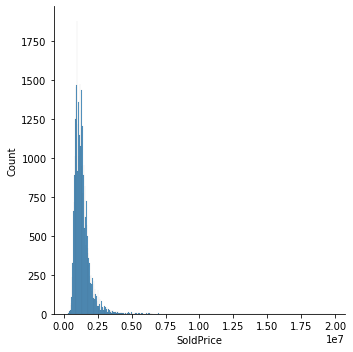

In [62]:
sns.displot( x="SoldPrice", data = houses_clean)

Rightly skewed with some outliers to the right, lets see this with a box and whisker plot

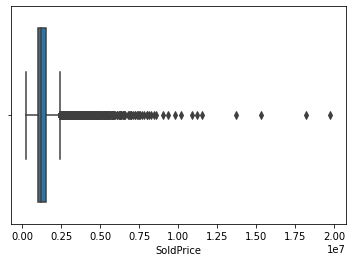

In [63]:
sns.boxplot(x=houses_clean["SoldPrice"])
plt.show()

 - Since I am not a millionaire(yet)for the purpose of my house hunting project I would be limiting the dataset to properties with 2 - 4 Bedrooms
- This falls within what I'm searching as well as its what's affordable for a lot of people given the craziness of the house market 
- Removing these will also help getting rid of outliers that could skew the mean which essentially results in better predictions

Lets remove those high number bedrooms to see if we can get a better distribution

In [64]:
aff_homes = houses_clean[houses_clean['Bed'].isin(range(2, 5))]

In [67]:
aff_homes['Bed'].value_counts()

3    19733
4    15542
2     1767
Name: Bed, dtype: int64

In [65]:
aff_homes.shape

(37042, 12)

Less outliers than before

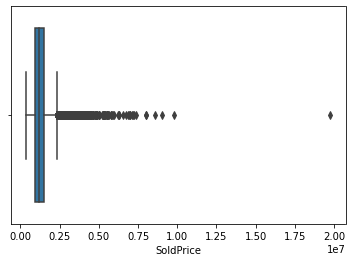

In [66]:
sns.boxplot(x=aff_homes["SoldPrice"])
plt.show()

Visualising the distribution of all columns . Look at the price columns, I can see that the outliers are still skewing the distribution which may give misleading results at the end. I want to get it as close to a normal distribution as much as I can

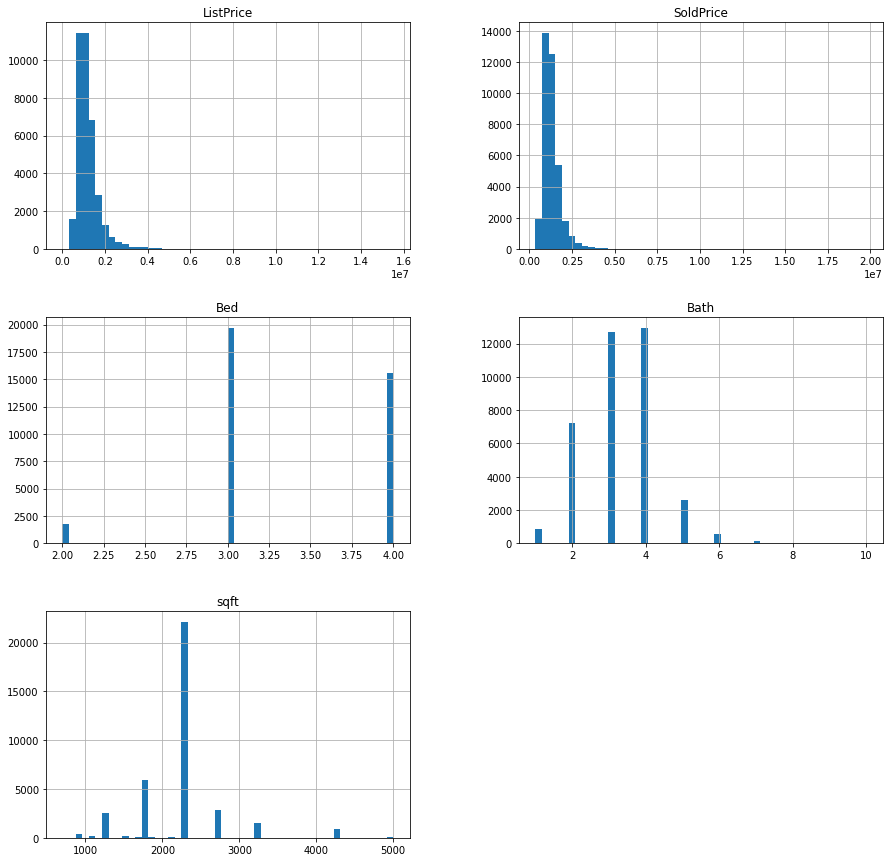

In [103]:
aff_homes.hist(bins=50, figsize=(15,15))
plt.ticklabel_format(style='plain')
#ax1.yaxis.get_offset_text().set_visible(False)
plt.show()


To get this close to a normal distribution, I'll remove further outliers using the IQR filters where the median is used to remove outliers that are further away

In [118]:
# Removing the outliers
def removeOutliers(df, col):
    Q3 = np.quantile(df[col], 0.75)
    Q1 = np.quantile(df[col], 0.25)
    IQR = Q3 - Q1
    global outlier_free_list
    global filtered_data

    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    outlier_free_list = [x for x in df[col] if ((x > lower_range) & (x < upper_range))]
    filtered_data = df.loc[df[col].isin(outlier_free_list)]

    
removeOutliers(aff_homes,'SoldPrice')
# Assigning filtered data back to our original variable
aff_homes = filtered_data
aff_homes.shape


(35479, 12)

Visualising the dataset after filtering outliers shows a better distribution of the dataset

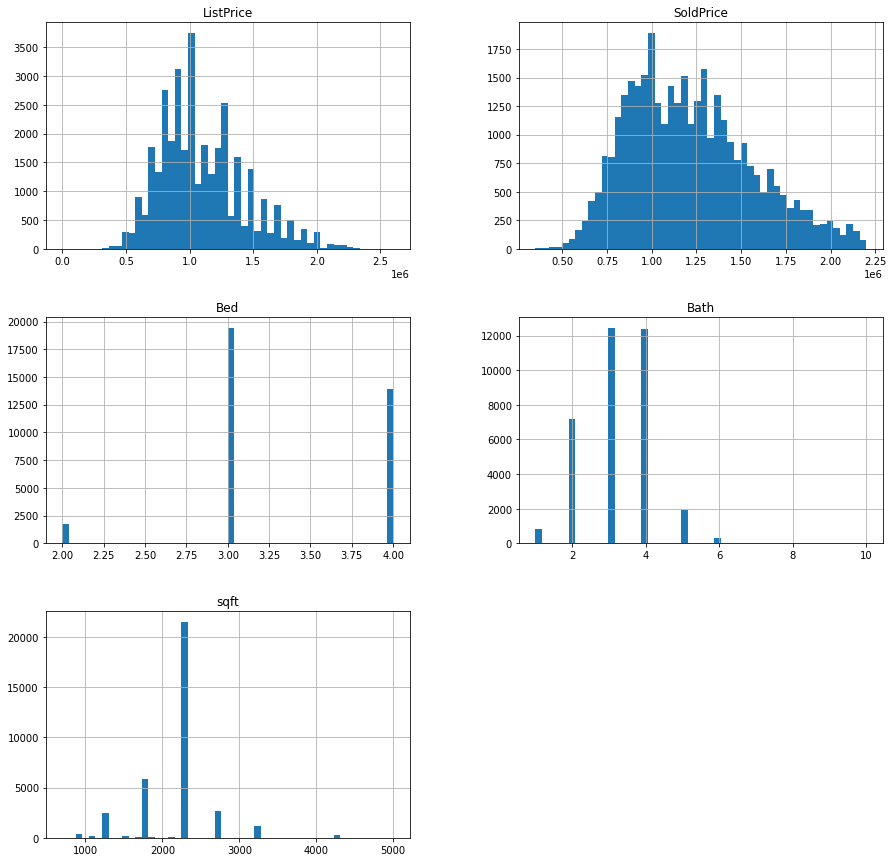

In [119]:

aff_h.hist(bins=50, figsize=(15,15))
plt.ticklabel_format(style='plain')
#ax1.yaxis.get_offset_text().set_visible(False)
plt.show()



Relationships - a pairplot to show relationships between the columns. The clear relationship is between price listing price and sold price

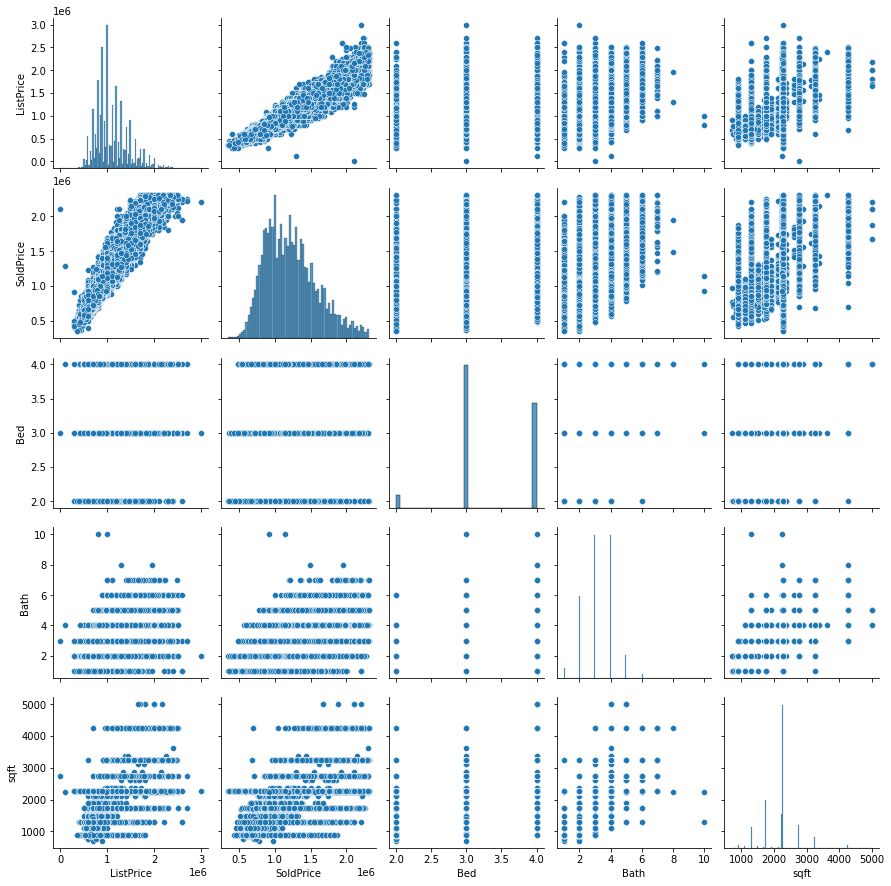

In [124]:
sns.pairplot(aff_homes)

The catplot shows the comparison of house price distribution in different cities. Markham, Vaughan, Richmond hill and oakville seems to have higher priced houses compared to a city like Oshawa where more of the houses falls towards the lower side of the price axis

<AxesSubplot:xlabel='City', ylabel='SoldPrice'>

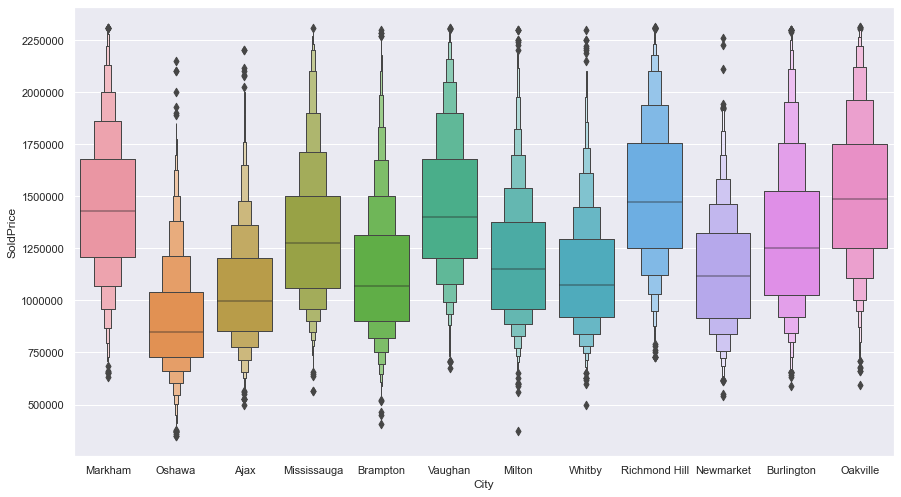

In [217]:
sns.set(rc={'figure.figsize':(14.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.boxenplot(x="City", y="SoldPrice", data=aff_homes)

Exploring property type and price, Houses seem to sell for more than condos which make sense . The townhomes and condos however around the 2 million point which begs the question of whether there are areas where condos are priced higher , in an expensive city like Oakville for example? 

<AxesSubplot:xlabel='Type', ylabel='SoldPrice'>

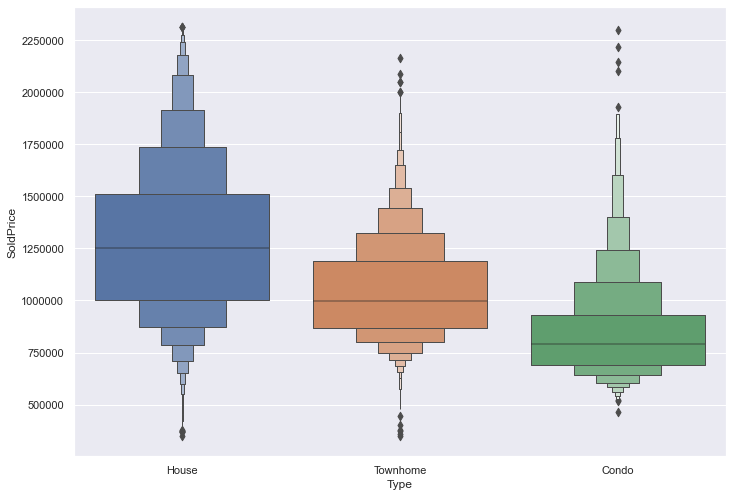

In [216]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)

sns.boxenplot(x="Type", y="SoldPrice",data=aff_homes)

Plotting City and housetype again median property prices, I can see that houses are more expensive in all cities than condos and townhomes. This further confirms what was seen with the box plot that Oshawa has cheaper houses compared to other cities. The median house price in Oakville is around 1.6M. Milton seems good for Condos has it has a lower median condo price compared to other cities.

-Question. Why are oakville houses so high in price? 

<AxesSubplot:xlabel='City', ylabel='SoldPrice'>

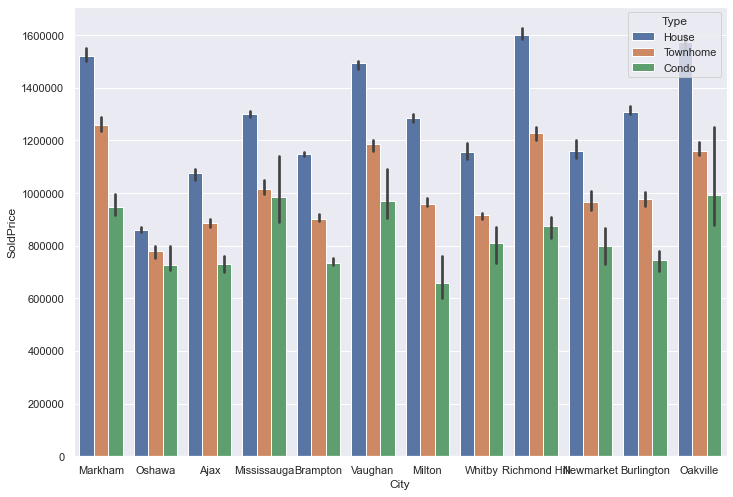

In [219]:

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.barplot(x="City", y="SoldPrice", hue="Type", data=aff_homes, estimator=np.median)

Brampton and Mississauga seem to have more sold houses than other places

<AxesSubplot:xlabel='City', ylabel='count'>

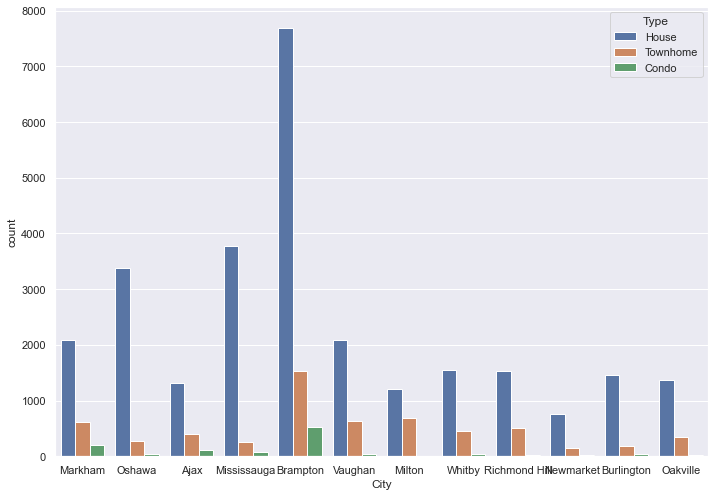

In [227]:
sns.countplot(x='City',data=aff_homes, hue='Type')


To see what's happening overtime, a lineplot is used below and it shows that prices of properties after hitting a high point in feb 20222 , they are now fluctuating a lot around April 2022

<AxesSubplot:xlabel='SoldDate', ylabel='SoldPrice'>

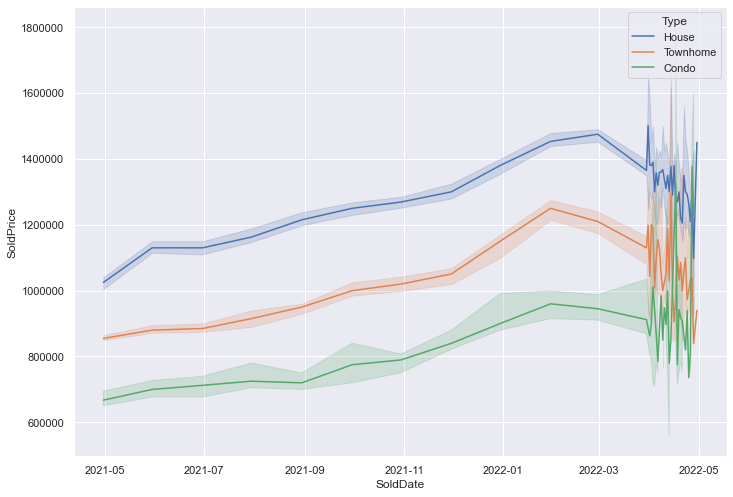

In [233]:
plt.ticklabel_format(style='plain', axis='y',useOffset=False)
sns.lineplot(data=aff_homes, x="SoldDate", y="SoldPrice", hue ='Type',  estimator=np.median)

In [123]:
data = {'City':['Oshawa','Ajax','Brampton','Burlington','Markham','Milton','Mississauga','Newmarket','Oakville','Richmond Hill','Vaughan','Whitby'],
        'median_income':[70211,96949,87290,93588,89028,104730,83018,95489,113666,88353,105351,103809]}
pd.DataFrame.from_dict(data)     
        
        
        

,City,median_income
0,Oshawa,70211
1,Ajax,96949
2,Brampton,87290
3,Burlington,93588
4,Markham,89028
5,Milton,104730
6,Mississauga,83018
7,Newmarket,95489
8,Oakville,113666
9,Richmond Hill,88353


Feature Engineering (Median Income, Close Facilities, Dummy variable of types)